In [1]:
"""
    SSA generates a trajectory matrix X from the original series y
    by sliding a window of length dim. The trajectory matrix is aproximated
    using SVD. The last step reconstructs the series from the aproximated trajectory matrix.
"""

import scipy.linalg as linalg
import scipy.stats as stats
import numpy as np

try:
    from matplotlib import pyplot as plt
    import pylab
except:
    print("Plotting functions will be disabled. Can't import matplotlib")
    pass


def isscalar(x):
    """
    Returns true if x is scalar value
    :param x:
    :return:
    """
    return not isinstance(x, (list, tuple, dict, np.ndarray))


def nans(dims):
    """
    nans((M,N,P,...)) is an M-by-N-by-P-by-... array of NaNs.
    :param dims: dimensions tuple
    :return: nans matrix
    """
    return np.nan * np.ones(dims)


def ssa(y, dim) -> tuple:
    """
    Singular Spectrum Analysis decomposition for a time series
    Example:
    -------
    >>> import numpy as np
    >>>
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    :param y: time series (array)
    :param dim: the embedding dimension
    :return: (pc, s, v) where
             pc is the matrix with the principal components of y
             s is the vector of the singular values of y given dim
             v is the matrix of the singular vectors of y given dim
    """
    n = len(y)
    t = n - (dim - 1)

    yy = linalg.hankel(y, np.zeros(dim))
    yy = yy[:-dim + 1, :] / np.sqrt(t)

    # here we use gesvd driver (as in Matlab)
    _, s, v = linalg.svd(yy, full_matrices=False, lapack_driver='gesvd')

    # find principal components
    vt = np.matrix(v).T
    pc = np.matrix(yy) * vt

    return np.asarray(pc), s, np.asarray(vt)


def inv_ssa(pc: np.ndarray, v: np.ndarray, k) -> np.ndarray:
    """
    Series reconstruction for given SSA decomposition using vector of components
    Example:
    -------
    >>> import numpy as np
    >>> from matplotlib import pyplot as plt
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    >>>
    >>> yr = inv_ssa(pc, v, [0,1])
    >>> plt.plot(x, yr)
    :param pc: matrix with the principal components from SSA
    :param v: matrix of the singular vectors from SSA
    :param k: vector with the indices of the components to be reconstructed
    :return: the reconstructed time series
    """
    if isscalar(k): k = [k]

    if pc.ndim != 2:
        raise ValueError('pc must be a 2-dimensional matrix')

    if v.ndim != 2:
        raise ValueError('v must be a 2-dimensional matrix')

    t, dim = pc.shape
    n_points = t + (dim - 1)

    if any(filter(lambda x: dim < x or x < 0, k)):
        raise ValueError('k must be vector of indexes from range 0..%d' % dim)

    pc_comp = np.asarray(np.matrix(pc[:, k]) * np.matrix(v[:, k]).T)

    xr = np.zeros(n_points)
    times = np.zeros(n_points)

    # reconstruction loop
    for i in range(dim):
        xr[i : t + i] = xr[i : t + i] + pc_comp[:, i]
        times[i : t + i] = times[i : t + i] + 1

    xr = (xr / times) * np.sqrt(t)
    return xr


def ssa_predict(x, dim, k, n_forecast, e=None, max_iter=10000) -> np.ndarray:
    """
    Series data prediction based on SSA
    Example:
    >>> x = np.linspace(0,5,1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>>
    >>> # make prediction for next 200 points
    >>> ys = ssa_predict(y, 100, [0,1,2], 200, 0.01)
    >>> 
    >>> # plot prediction
    >>> plt.figure(figsize=(16,8));
    >>> x0 = len(y); plt.plot(range(x0), y); plt.plot(range(x0, x0 + len(ys)), ys, 'r--')
    >>> plt.legend(['Data', 'Forecast'])
    :param x: series to be predicted
    :param dim: the embedding dimension
    :param k: components indexes for reconstruction
    :param n_forecast: number of points to forecast
    :param e: minimum value to ensure convergence
    :param max_iter: maximum number of iterations
    :return: forecasted series
    """
    if not e:
        e = 0.0001 * (np.max(x) - np.min(x))
    mean_x = x.mean()
    x = x - mean_x
    xf = nans(n_forecast)

    for i in range(n_forecast):
        # here we use previous value as initial estimation
        x = np.append(x, x[-1])
        yq = x[-1]
        y = yq + 2 * e
        n_iter = max_iter
        while abs(y - yq) > e:
            yq = x[-1]

            pc, _, v = ssa(x, dim)
            xr = inv_ssa(pc, v, k)

            y = xr[-1]
            x[-1] = y
            n_iter -= 1
            if n_iter <= 0:
                print('ssa_predict> number of iterations exceeded')
                break

        xf[i] = x[-1]
    xf = xf + mean_x
    return xf


def ssa_cutoff_order(x: np.ndarray, dim=200, cutoff_pctl=75, show_plot=False):
    """
    Tries to find best cutoff for number of order when increment changes of informational entropy
    becomes little and the effective information saturates.
    :param x: series
    :param dim: embedding dimensions (200 by default)
    :param cutoff_pctl: percentile of changes (75%)
    :param show_plot: true if we need to see informational curve
    :return: cutoff number
    """
    _, s, _ = ssa(x, dim)
    curve = -s/s.sum() * np.log(s/s.sum())
    pctl = np.percentile(curve, cutoff_pctl)
    n_cutoff = sum(curve > pctl)
    
    if show_plot:
        plt.plot(curve)
        plt.ylabel('Increment of Singular Entropy')
        plt.xlabel('Number of Order')
        plt.vlines(n_cutoff, 0, max(curve), 'g', linestyles='dotted')
        plt.text(dim*0.6, max(curve)*0.9, 'Cutoff order: %d' % n_cutoff)
        
    return n_cutoff


def ssaview(y, dim, k):
    """
    Visualising tools for singular spectrum analysis
    Example:
    -------
    >>> import numpy as np
    >>>
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> ssaview(y, 15, [0,1])
    :param y: series
    :param dim: the embedding dimension
    :param k: components indexes for reconstrunction
    """
    pc, s, v = ssa(y, dim)
    yr = inv_ssa(pc, v, k)

    plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
    plt.title('Singular Spectrum View for %d window length' % dim)
    plt.plot(y, color='#6ec0fa', lw=1.2)
    plt.plot(yr, 'r', lw=1)
    plt.ylabel('Series')
    plt.legend(['Original', 'Reconstructed'])

    # residuals chart
    plt.subplot2grid((3, 3), (2, 0), colspan=2)
    plt.plot(y - yr, 'g', lw=1)
    plt.ylabel('Residual')
    plt.legend(['Residual'])
    plt.xlabel('Data points')

    # resuduals qq-plot
    plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    stats.probplot(y - yr, dist="norm", plot=pylab)
    plt.title('Residuals QQ plot')

    # singular values
    plt.subplot2grid((3, 3), (2, 2))
    plt.title('Singular spectrum')
    plt.plot(100 * s / s.sum(), 'g', marker='*', lw=1, alpha=0.6)
    plt.xlabel('Eigenvalue number')
    plt.ylabel('Eigenvalue')

In [2]:
    import speech_recognition as sr
    from os import path
    import os.path
    import operator
    from os import system
    from os import listdir
    from os.path import isfile, join
    import wave
    import scipy as sc
    import librosa
    import IPython.display as ipd
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    import matplotlib
    import numpy as np
    %matplotlib inline
    import math
    import librosa as lb
    import scipy
    from sklearn.decomposition import PCA
    import pandas as pd
    from os import listdir
    from os.path import isfile, join
    import time
    from itertools import product
    import datetime
    import sys
    import scipy.io.wavfile

In [3]:
fs, data = scipy.io.wavfile.read("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/Audio2.wav")
print(len(data))

95734


In [4]:
h = [3, 4]
print(h)

[3, 4]


In [5]:
#Squares both the phase signals and adds them together
def getSignalSum(a, b):
    x = (a**2) + (b**2)
    return x

In [6]:
#Obtains the magnitude of the signalSums
def getMagnitude(x):
    ans = math.sqrt(x)
    return ans

In [7]:
print("This is the signal sum: ",getSignalSum(3,4))
signalSum = getSignalSum(3,4)
print(np.power(np.abs(3+4j), 2))
print("This is the magnitude of the signal: ",getMagnitude(signalSum))
magnitude = getMagnitude(signalSum)

This is the signal sum:  25
25.0
This is the magnitude of the signal:  5.0


In [8]:
#Sets the upper bound on possible value that a signal can be
def signalBound(y):
    maxNum = np.sqrt(y)
    return maxNum
    

In [9]:
maxNum = signalBound(signalSum)
print("This is the highest value that a new\nsignal number can be to have the same magnitude:\n",maxNum)

This is the highest value that a new
signal number can be to have the same magnitude:
 5.0


In [10]:
def sum_to_n(n, size, limit=None):
    """Produce all lists of `size` positive integers in decreasing order
    that add up to `n`."""
    if size == 1:
        yield [n]
        #list.append([n])
        return
    if limit is None:
        limit = n
    start = (n + size - 1) // size
    stop = min(limit, n - size + 1) + 1
    for i in np.arange(start, stop):
        for tail in sum_to_n(n - i, size - 1, i):
            yield np.sqrt([i] + tail)
            #list.append(np.sqrt([i] + tail))

In [11]:
#Create a new empty list to store the answers
listAns = []
result = []

In [12]:
for x in sum_to_n(np.power(np.abs(-2.42218600e+06+1.22079065e-12j)*.0001, 2), 2):
    #add the result to a list
    result.append(x)
    #print(x)
    break

In [13]:
print(result)
print(type(result))

[array([171.27463326, 171.27419591])]
<class 'list'>


In [14]:
data = np.asarray(result)
print(data)


[[171.27463326 171.27419591]]


In [15]:
import speech_recognition as sr
from os import path
import os.path
import operator
from os import system
from os import listdir
from os.path import isfile, join
import wave
import scipy as sc
import librosa
import IPython.display as ipd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import math
import librosa as lb
import scipy
from sklearn.decomposition import PCA
import pandas as pd
from os import listdir
from os.path import isfile, join
import time
from itertools import product
import datetime
import sys



fs, data = scipy.io.wavfile.read("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/Audio2.wav")
print(len(data))


h = [3, 4]
print(h)


#Squares both the phase signals and adds them together
def getSignalSum(a, b):
    x = (a**2) + (b**2)
    return x


#Obtains the magnitude of the signalSums
def getMagnitude(x):
    ans = math.sqrt(x)
    return ans



print("This is the signal sum: ",getSignalSum(3,4))
signalSum = getSignalSum(3,4)
print(np.power(np.abs(3+4j), 2))
print("This is the magnitude of the signal: ",getMagnitude(signalSum))
magnitude = getMagnitude(signalSum)



#Sets the upper bound on possible value that a signal can be
def signalBound(y):
    maxNum = np.sqrt(y)
    return maxNum
    

maxNum = signalBound(signalSum)
print("This is the highest value that a new\nsignal number can be to have the same magnitude:\n",maxNum)



def sum_to_n(n, size, limit=None):
    """Produce all lists of `size` positive integers in decreasing order
    that add up to `n`."""
    if size == 1:
        yield [n]
        #list.append([n])
        return
    if limit is None:
        limit = n
    start = (n + size - 1) // size
    stop = min(limit, n - size + 1) + 1
    for i in np.arange(start, stop):
        for tail in sum_to_n(n - i, size - 1, i):
            yield np.sqrt([i] + tail)
            #list.append(np.sqrt([i] + tail))



#Create a new empty list to store the answers
listAns = []
result = []

for x in sum_to_n(np.power(np.abs(-2.42218600e+06+1.22079065e-12j)*.0001, 2), 2):
    #add the result to a list
    result.append(x)
    #print(x)
    break


print(result)
print(type(result))


data = np.asarray(result)
print(data)









95734
[3, 4]
This is the signal sum:  25
25.0
This is the magnitude of the signal:  5.0
This is the highest value that a new
signal number can be to have the same magnitude:
 5.0
[array([171.27463326, 171.27419591])]
<class 'list'>
[[171.27463326 171.27419591]]


In [16]:
import speech_recognition as sr
from os import path
import os.path
import operator
from os import system
from os import listdir
from os.path import isfile, join
import wave
import scipy as sc
import librosa
import IPython.display as ipd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import math
import librosa as lb
import scipy
from sklearn.decomposition import PCA
import pandas as pd
from os import listdir
from os.path import isfile, join
import time
from itertools import product
import datetime
import sys
from scipy.fft import fft, fftfreq

In [18]:
fs, data = scipy.io.wavfile.read("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1.wav")
length = len(data)

print("This is the length of the data:", len(data))
print("This is the data printed\n", data[-100:])

This is the length of the data: 38432
This is the data printed
 [[-4 -1]
 [-4 -1]
 [-2 -2]
 [-1 -4]
 [-1 -4]
 [-1 -3]
 [-1 -2]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-3  0]
 [-4  0]
 [-3 -2]
 [-4 -3]
 [-2 -1]
 [ 1  0]
 [ 0 -2]
 [-1 -2]
 [-1 -2]
 [-2 -3]
 [-2 -2]
 [-2 -1]
 [-3 -3]
 [-1 -4]
 [ 0 -3]
 [ 0 -3]
 [-1 -4]
 [-2 -4]
 [-2 -3]
 [ 0 -2]
 [ 1 -2]
 [-1 -2]
 [-2 -3]
 [-1 -2]
 [-1 -2]
 [-2 -4]
 [-2 -3]
 [-1 -1]
 [-3  0]
 [-4  1]
 [-4  1]
 [-4 -1]
 [-2 -2]
 [-2 -2]
 [-3 -3]
 [-3 -4]
 [-4 -6]
 [-5 -7]
 [-5 -6]
 [-6 -5]
 [-7 -6]
 [-7 -6]
 [-6 -6]
 [-6 -5]
 [-6 -4]
 [-6 -5]
 [-6 -7]
 [-8 -7]
 [-8 -6]
 [-7 -5]
 [-7 -4]
 [-8 -4]
 [-8 -3]
 [-6 -2]
 [-4 -2]
 [-3 -2]
 [-1 -2]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [ 2  0]
 [ 4  1]
 [ 4  1]
 [ 3  1]
 [ 4  2]
 [ 6  3]
 [ 7  4]
 [ 5  3]
 [ 4  2]
 [ 4  2]
 [ 5  4]
 [ 5  3]
 [ 5  3]
 [ 5  4]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 7  6]
 [10  7]
 [11  8]
 [12 10]
 [12 12]
 [10 10]
 [11 11]
 [11 11]]


In [19]:
print(type(data))

<class 'numpy.ndarray'>


In [20]:
a = data
print("This is the last 20 numbers of the data:\n\n",a[-20:])

This is the last 20 numbers of the data:

 [[ 6  3]
 [ 7  4]
 [ 5  3]
 [ 4  2]
 [ 4  2]
 [ 5  4]
 [ 5  3]
 [ 5  3]
 [ 5  4]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 7  6]
 [10  7]
 [11  8]
 [12 10]
 [12 12]
 [10 10]
 [11 11]
 [11 11]]


Creates a list of the complex numbers
 [[ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 7.-0.j -1.-0.j]
 [ 8.-0.j  0.-0.j]
 [ 8.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]] 


This is half of the spectrum
 [[ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 7.-0.j -1.-0.j]
 [ 8.-0.j  0.-0.j]
 [ 8.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]
 [10.-0.j  0.-0.j]]


/Users/sahajathota/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


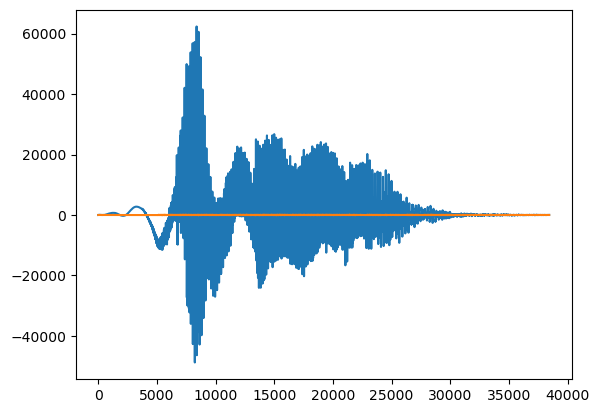

In [21]:
#fast fourrier transform
#This is the FFT of the data
from scipy.fft import fft, fftfreq
b = sc.fft.fft(a)
plt.plot(b)
plt.savefig("figure.png") # save as png

print("Creates a list of the complex numbers\n",b[:15],"\n")


#Gets half of the spectrum, using ceil to obtain the middle value in case of an odd length
c= b[0:int(np.ceil((length+1)/2.0))] 
print("\nThis is half of the spectrum\n", c[:15])
#print("\n","Validates this is only half of the length:" ,len(b), ", ", len(c))

In [22]:
#take the magnitude of the FFT
magFreq = np.absolute(c)
print(magFreq[:15])

magFreq2 = magFreq

[[ 2.  0.]
 [ 2.  0.]
 [ 2.  0.]
 [ 2.  0.]
 [ 4.  0.]
 [ 4.  0.]
 [ 4.  0.]
 [ 6.  0.]
 [ 6.  0.]
 [ 7.  1.]
 [ 8.  0.]
 [ 8.  0.]
 [10.  0.]
 [10.  0.]
 [10.  0.]]


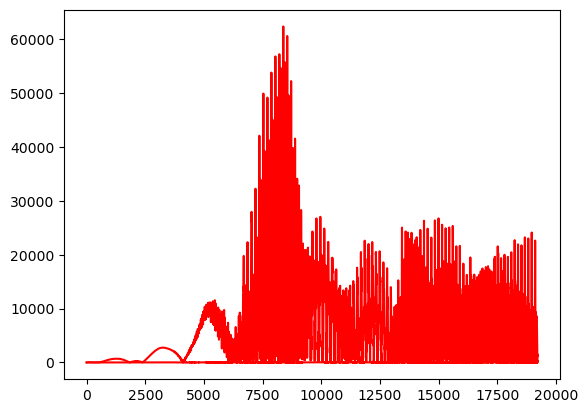

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(magFreq, 'r')
plt.show()
plt.savefig("figure.png") # save as png


In [24]:
magFreq2[:10]

array([[2., 0.],
       [2., 0.],
       [2., 0.],
       [2., 0.],
       [4., 0.],
       [4., 0.],
       [4., 0.],
       [6., 0.],
       [6., 0.],
       [7., 1.]])

In [25]:
def transcribe(my_path,model):
    wit_key = ''

    AUDIO_FILE =  path.join(my_path)

    # use the audio file as the audio source
    r = sr.Recognizer()
    with sr.AudioFile(my_path) as source:
        audio = r.record(source)  # read the entire audio file

    if(model == 'google'):
        # Google
        try:
            return r.recognize_google(audio)
        except sr.UnknownValueError:
             print("Google: -_-")
            
        except sr.RequestError as e:
            print("Google error; {0}".format(e))

In [26]:
from scipy.io.wavfile import write
import numpy as np
from transcribe import transcribe

fs = 44100  # Sample rate
duration = 5  # Duration in seconds

# Generate a sine wave of 440 Hz
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 440
sine_wave = 0.5 * np.sin(2 * np.pi * freq * t)

# Convert the sine wave to a 16-bit integer array
sine_wave_int = np.int16(sine_wave * 32767)

# Write the sine wave to a WAV file
write('/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1.wav', fs, sine_wave_int)

# Transcribe the WAV file using Google Speech Recognition API
transcribe('/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1.wav', 'google')


ModuleNotFoundError: No module named 'transcribe'

In [27]:
scipy.io.wavfile.write("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1", fs, magFreq2)
transcribe("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1", "google")

ValueError: Audio file could not be read as PCM WAV, AIFF/AIFF-C, or Native FLAC; check if file is corrupted or in another format

In [28]:
import speech_recognition as sr
from os import path
import os.path
import operator
from os import system
from os import listdir
from os.path import isfile, join
import wave
import scipy as sc
import librosa
import IPython.display as ipd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import math
import librosa as lb
import scipy
from sklearn.decomposition import PCA
import pandas as pd
from os import listdir
from os.path import isfile, join
import time
from itertools import product
import datetime
import sys

In [29]:
#Read in the amplitude of the audio file
fs, data = scipy.io.wavfile.read("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1.wav")
length = len(data)
print("This is the data printed\n", data[-100:])

This is the data printed
 [[-4 -1]
 [-4 -1]
 [-2 -2]
 [-1 -4]
 [-1 -4]
 [-1 -3]
 [-1 -2]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-3  0]
 [-4  0]
 [-3 -2]
 [-4 -3]
 [-2 -1]
 [ 1  0]
 [ 0 -2]
 [-1 -2]
 [-1 -2]
 [-2 -3]
 [-2 -2]
 [-2 -1]
 [-3 -3]
 [-1 -4]
 [ 0 -3]
 [ 0 -3]
 [-1 -4]
 [-2 -4]
 [-2 -3]
 [ 0 -2]
 [ 1 -2]
 [-1 -2]
 [-2 -3]
 [-1 -2]
 [-1 -2]
 [-2 -4]
 [-2 -3]
 [-1 -1]
 [-3  0]
 [-4  1]
 [-4  1]
 [-4 -1]
 [-2 -2]
 [-2 -2]
 [-3 -3]
 [-3 -4]
 [-4 -6]
 [-5 -7]
 [-5 -6]
 [-6 -5]
 [-7 -6]
 [-7 -6]
 [-6 -6]
 [-6 -5]
 [-6 -4]
 [-6 -5]
 [-6 -7]
 [-8 -7]
 [-8 -6]
 [-7 -5]
 [-7 -4]
 [-8 -4]
 [-8 -3]
 [-6 -2]
 [-4 -2]
 [-3 -2]
 [-1 -2]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [ 2  0]
 [ 4  1]
 [ 4  1]
 [ 3  1]
 [ 4  2]
 [ 6  3]
 [ 7  4]
 [ 5  3]
 [ 4  2]
 [ 4  2]
 [ 5  4]
 [ 5  3]
 [ 5  3]
 [ 5  4]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 7  6]
 [10  7]
 [11  8]
 [12 10]
 [12 12]
 [10 10]
 [11 11]
 [11 11]]


In [30]:
a = data

#Take the FFT of the time domain frequency 
b = sc.fft.fft(a)

#Gets half of the spectrum, using ceil to obtain the middle value in case of an odd length
#Only need half of it because real and imaginary data are symmertrial and data duplicates after half way
c= b[0:int(np.ceil((length+1)/2.0))]

#Store new length of the array
lenFreq = len(c)

#Take the magnitude of the FFT for original audio
magFreq = np.absolute(c)

In [31]:
print("This is magFreq:\n", magFreq)
print("\n", c)
print(np.abs(4+3j))
print(c[:10])

This is magFreq:
 [[  2.   0.]
 [  2.   0.]
 [  2.   0.]
 ...
 [379.  13.]
 [143.   3.]
 [273.  11.]]

 [[   2.-0.j    0.-0.j]
 [   2.-0.j    0.-0.j]
 [   2.-0.j    0.-0.j]
 ...
 [-379.-0.j  -13.-0.j]
 [-143.-0.j   -3.-0.j]
 [ 273.-0.j   11.-0.j]]
5.0
[[ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 2.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 4.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 6.-0.j  0.-0.j]
 [ 7.-0.j -1.-0.j]]


In [32]:
"""Produce all lists of `size` positive integers in decreasing order
    that add up to `n`."""
def sum_to_n(n, size, limit=None):
    if size == 1:
        yield [n]
        #list.append([n])
        return
    if limit is None:
        limit = n
    start = (n + size - 1) // size
    stop = min(limit, n - size + 1) + 1
    for i in np.arange(start, stop):
        for tail in sum_to_n(n - i, size - 1, i):
            yield (np.sqrt([i] + tail))
            list.append(np.sqrt([i] + tail))

In [33]:
#Stores the original real and imaginary numbers in a list
realNumbers = []
imaginaryNumbers = []

#Stores the magnitudes for the pertubated audio clip
magFreq2 = []

#Stores the modified real and imaginary numbers in a list
realFinal = []
imagFinal = []

#Stores the results in the following lists 
resultsTemp = []
finalResults = []

for i in range(lenFreq-1):
    #Stores the result inside of real numbers list
    realNumbers.append(c[i].real)
    
    #Stores the numbers inside of imaginary numbers list
    imaginaryNumbers.append(c[i].imag)
    
    #Stores the magnitude inside of the list
    #Uses the abs function to be able to compute the magnitude
    valueToUseInSumN = np.vectorize(complex(c[i].imag*1j + c[i].real))
    magFreq2.append(np.vectorize(valueToUseInSumN, 2))
    
    for x in sum_to_n(magFreq2[i]*.0001, 2):
        #add the result to a list
        resultsTemp.append(x)
        break
    
    finalResults.append(resultsTemp[0][0] + complex(resultsTemp[0][1])*1j)
    
    realFinal.append(finalResults[i].real * 100)
    imagFinal.append(finalResults[i].imag* 1j* 100)
    
    resultsTemp.clear()

TypeError: only length-1 arrays can be converted to Python scalars

In [34]:
magFreq3 = []

In [35]:
results = []

In [36]:
for x in sum_to_n(magFreq2[1], 2):
    #add the result to a list
    results.append(x)
    #print(x)
    break

IndexError: list index out of range

In [37]:
#testing
import speech_recognition as sr
from os import path
import os.path
import operator
from os import system
from os import listdir
from os.path import isfile, join
import wave
import scipy as sc
import scipy.io.wavfile
import librosa
import IPython.display as ipd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import math
import librosa as lb
import scipy
from sklearn.decomposition import PCA
import pandas as pd
from os import listdir
from os.path import isfile, join
import time
from itertools import product
import datetime
import sys

In [38]:
fs, data = scipy.io.wavfile.read("/Users/sahajathota/Downloads/SEN1/PRO/MID/Code/helloAudio1.wav")
print(len(data))

38432


In [39]:
h = [3+4j]
print(h)

[(3+4j)]


In [40]:
#Squares both the phase signals and adds them together
def getMagnitude(a):
    x = np.abs(a)
    return x

In [41]:
print("This is the magnitude of the signal: ",getMagnitude(h))

magnitudeNum = getMagnitude(h)

signalSum = np.power(np.abs(3+4j), 2)

print("\nThis is the signal sum: ",signalSum, "\n")



This is the magnitude of the signal:  [5.]

This is the signal sum:  25.0 



In [42]:
def sum_to_n(n, size, limit=None):
    """Produce all lists of `size` positive integers in decreasing order
    that add up to `n`."""
    if size == 1:
        yield [n]
        #list.append([n])
        return
    if limit is None:
        limit = n
    start = (n + size - 1) // size
    stop = np.abs(complex(min(limit, n - size + 1) + 1))
    for i in np.arange(start, stop):
        for tail in sum_to_n(n - i, size - 1, i):
            yield np.sqrt([i] + tail)
            #list.append(np.sqrt([i] + tail))

In [43]:
#Create a new empty list to store the answers
listAns = []
result = []

In [44]:
for x in sum_to_n(signalSum, 2):
    #add the result to a list
    result.append(x)
    print(x)
    

[3.60555128 3.46410162]
[3.74165739 3.31662479]
[3.87298335 3.16227766]
[4. 3.]
[4.12310563 2.82842712]
[4.24264069 2.64575131]
[4.35889894 2.44948974]
[4.47213595 2.23606798]
[4.58257569 2.        ]
[4.69041576 1.73205081]
[4.79583152 1.41421356]
[4.89897949 1.        ]


In [45]:
type(result)

list

In [46]:
data = np.asarray(result)


In [47]:
data

array([[3.60555128, 3.46410162],
       [3.74165739, 3.31662479],
       [3.87298335, 3.16227766],
       [4.        , 3.        ],
       [4.12310563, 2.82842712],
       [4.24264069, 2.64575131],
       [4.35889894, 2.44948974],
       [4.47213595, 2.23606798],
       [4.58257569, 2.        ],
       [4.69041576, 1.73205081],
       [4.79583152, 1.41421356],
       [4.89897949, 1.        ]])

In [48]:
for i in range(5):
    for x in sum_to_n(signalSum, 2):
        result.append(x)
        break

In [49]:
result

[array([3.60555128, 3.46410162]),
 array([3.74165739, 3.31662479]),
 array([3.87298335, 3.16227766]),
 array([4., 3.]),
 array([4.12310563, 2.82842712]),
 array([4.24264069, 2.64575131]),
 array([4.35889894, 2.44948974]),
 array([4.47213595, 2.23606798]),
 array([4.58257569, 2.        ]),
 array([4.69041576, 1.73205081]),
 array([4.79583152, 1.41421356]),
 array([4.89897949, 1.        ]),
 array([3.60555128, 3.46410162]),
 array([3.60555128, 3.46410162]),
 array([3.60555128, 3.46410162]),
 array([3.60555128, 3.46410162]),
 array([3.60555128, 3.46410162])]

In [50]:
signalSum

25.0

In [51]:
result.clear()